## 👩🏾‍💻 The project is from [Kaggle competition](https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels/edit/run/158964232). Please click through 👈 to get more details.

<a id="0"></a> <br>
 # Table of Contents  

- Part 0:  [Project Introduction](#1)
- Part 1:  [Data EDA and pre-processing](#2)   
  - 1.1  [Import files and load data](#3)
  - 1.2  [Basic data inspectations](#4)
  - 1.3  [Deeper EDA and Data cleaning (none NLP specific)](#5)
  - 1.4  [Data preprocessing for NLP](#6)
  - 1.4.1  [Text documents EDA](#7)
  - 1.4.2  [Text preprocessing](#8)
- Part 2:  [Matrix Factorization training and predictions](#9)
  - 2.1  [Label permutations and mapping](#10)
  - 2.2  [Model trainings and predictions](#11)
  - 2.3  [Model Tuning](#12)
  - 2.4  [Further model improvement? - Ensemble approach](#13)
- Part 3: [Comparison with a supervised model - random forest](#14)
  - 3.1 [Random Forest training, prediction, and comparison with NMF](#15)
  - 3.2 [How Random Forest perform on portions of labeled data](#16)
  - 3.3 [How NMF perform on portions of labeled data](#17)
- Part 4: [Conclusion](#18)
- [References](#19)




# <a id="1"></a>
# Part 0: Project introduction
- **Data**:
  - Public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech. The dataset is broken into 1490 records for training and 735 for testing.
- **Goal**:
  - In real life, labeled data is scarce while usually we have lots of unlabeled data. In cases with limited labeled data, unsupervised learning model can be powerful. In this project, we will try to build an **unsupervised** learning model that can accurately classify previously unseen news articles into the right category. While there are many unsupervised learning models to do this, I'll only focus on exploring **Matrix Factorization** learning model. I'll then compare it with one supervised learning model.

- **Project plan**
  - The flow of the project can be seen in the content table above. Essentially, there are 3 parts:

    - EDA, data cleaning, and preprocessing
       - I will do some general EDA first including checking duplicates (there are some). Since it's classification problem, it's important to check if the data is balanced.
       - Then, I'll do some EDA and data pre-processing specific for text data. Note for text data, we need to transform the text documents to some feature vectors. There are many ways to do this but I will use **TFIDF**. We will introduce a bit about TFIDF and discuss about **text preprocessing**.
    - Matrix Factorization model training and predictions
      - We will introduce a bit about **matrix factorization**
      - We will discuss why we can't put testing data when we do training in general.
      - Accuracy is the set metric for this computation so I will mainly focus on that. Since this is a multi-class classification (so that accuracy isn't everything especially when the data isn't balanced), I will use confusion matrix so it will show how exactly the classes are predicted.
      - I will put some parameters and submit the results first. Then, I will **tune the model** and see how results improve
      - For further improvement, I will try an **ensemble method** from which I would randomly select portions of samples with no replacement and train several models. Then, let those models predict testing results seperately.
    - Model comparison
      - I will choose a supervise model for comparison. The model I choose is **random forest** since it usually work well when there are many features (after TFIDF). But honestly I didn't put too much effect into choosing the best supervising model since this isn't the focus of this project.
      - I will compare **train/testing accuracies** and **overfitting** problems of NMF vs. the random forest models. Note although random forest model represent the supervised model, I haven't tried many other supervised models. So, it's definitely not the 'battle' of supervised vs. not supervised model!
      - I will also try **changing the labeled train data size** for random forest and NMF models and do comparison. We know random forest is a supervised learning model so the labeled data size we try has to be equal to the training data size. For NMF though, it's an unsupervised learning model but we do need some labels to figure out the NMF label to ground truth label (5 categories in this project) mapping but how small (**'data-efficient'**) is it for this project? Let's see!
  


# <a id="2"></a>
# Part 1: Exploratory Data Analysis (EDA) and data pre-processing




# <a id="3"></a>
## Part 1.1: Import files and load data


In [ ]:
# Import files

# General files
import os
import numpy as np
import pandas as pd
from scipy.stats import mode
import itertools
import re # Regular expression

# Visualization files
import matplotlib.pyplot as plt
import seaborn as sns

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# models and tuning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix



In [ ]:
# Load data

# Take a look at directories and file names
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import files from directories
root_directory = '/kaggle/input/learn-ai-bbc'
train = pd.read_csv(os.path.join(root_directory, "BBC News Train.csv"))
sample_sol = pd.read_csv(os.path.join(root_directory, "BBC News Sample Solution.csv"))
test = pd.read_csv(os.path.join(root_directory, "BBC News Test.csv"))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# <a id="4"></a>
## Part 1.2: Basic data inspectations
After loading data files, I will just do some basic ("no-brainer") but useful data inspectations like .head(), .info() that I do for most projects to just glace at the loaded data to get a feel of things like data size, data columns, column types etc. and also to make sure I loaded data correctly.

In [ ]:
# take a quick look at data
print("train: \n",train.head(),"\n")
print("test: \n",test.head(),"\n")
print("sample_sol: \n",sample_sol.head())

train: 
    ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business 

test: 
    ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough... 

sample_sol: 
    ArticleId       Category
0       1018          sport
1       1319           tech
2       1138       business
3        459  entertainme

In [ ]:
# Use info() to get some basic informations (data size, column types)
print("train: \n")
print(train.info())
print("test: \n")
print(test.info())
print("sample_sol: \n")
print(sample_sol.info())

train: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
test: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None
sample_sol: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory u

#### From a first glance, I have a few basic understanding of the data:
* Data was splitted into train and test. Sample solution file is just a sample of our goal output file.
* There are 1490 samples in the training data and 735 in the testing data, each with 3 columns (ArticleID, Text,and Category)
* Except for 'ArticleID", which has integer data type, the other 2 columns ('Text' and 'Category') have object data type. Those data types are what I expected.
* There are no null values in data

I could also do a .describe() to check some statistics. But since this is text data (instead of a bunch of numerical ones), it won't help much. I will skip for now (I actually quickly did it but decided to not show it here） and do some other EDA in the following steps.

# <a id="5"></a>
## Part 1.3: Deeper EDA and Data cleaning (none NLP specific)

- Okay, so it's good that there are no null values and the data types are what they should be. I want to check a couple of things next:
  - How the target variable 'Category' distributed. Are there any unexpected values? Are they balanced?
  - Any duplicated values

The details of plan of analysis above will depend on more of my EDA along the way. I will explain step by step. I have to say above is not lots of EDA or data cleaning but since it's text data, some analysis applied to other types of data isn't relevant here. For example, an age column might have some crazy data like an age of -10 or 300. For text data, we don't need to check stuff like this.

However, text data need some other types of data inspections and analysis. After this part, I will do more analysis and data pre-processing that are NLP specific. Stay tuned!

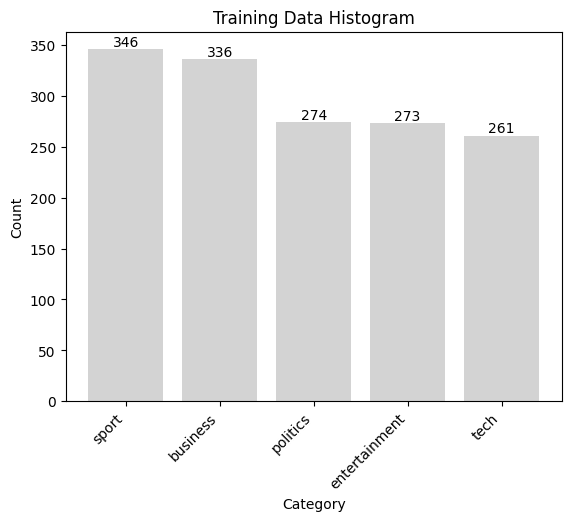

In [ ]:
# Since the goal is to predict the topic ('Cateogry') of a given text, let's see it's distribution
category_counts = train['Category'].value_counts()
plt.bar(category_counts.index, category_counts, color='lightgray')
plt.title('Training Data Histogram')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

#### Is the target variable 'Category' balanced?
It seems there are 5 categories (topics) in the training data: business, tech, politics,sport, and entertainment. From historgram, it maybe interesting to see that sport and business are the most popular topics, but what I really want to check (for prediction purpose) is whether the distribution is balanced. If the target variable isn't balanced, the accuracy metric used for this competition won't be a good one. For example, in extreme case if 99% of topic are sports, we would get 99% accuracy score by just predicting all documents to be sports.

From the historgram, the distribution isn't perfectly blanced but it isn't heavily imbalanced either. If they are imbalanced, I would need to 'manually' make them balance by doing things like [undersampling or oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) each class. For this case, I will leave them as they are for now.

Note as listed in the Kaggle competition overview, those are exactly the 5 classes we are going to predict for testing data. That was what I wanted to check and things look good here. There is nothing strange here.

I kind of wonder if all BBC news can all fit in those 5 topics though. If not, I wonder if the data is choosen in a specific way (only those BBC news of those 5 topics were chosen) or some "smoothing" is done when labeling. But I thnk this concern might not be relavant to this project.

#### Duplicated values
It's a good practice to check (and remove) duplicated values. I think with small amounts, it might be okay. But, if it's a lot, it might affect the model performance since it's basically change the data distribution (by have the same sample data too many times).

If there are any duplicated values, before removing them, I would like to inspect them a bit first to prevent removing things I don't meant to. How do they look like? Are the target value of those duplicates consistent (Does the same text have the same'Category')?

Let's inspect duplicated values first.

In [ ]:
# Count the duplicated values in the 'Text' column
duplicated_text_count = train.duplicated(subset=['Text']).sum()

# Count the duplicated values based on both 'Text' and 'Category'. If the counts are the same as above,those duplicates have consistent 'Category'
duplicated_textcat_count = train.duplicated(subset=['Text', 'Category']).sum()

# Print the counts
print(f'There are {duplicated_text_count} rows with the same texts in the training data.')
print(f'There are {duplicated_textcat_count} rows with the same texts and categories in the training data.')

# I am curious to see how those duplicates look like. Let's just look at a few.
duplicates = train[train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text')
print( duplicates.head(6) )


There are 50 rows with the same texts in the training data.
There are 50 rows with the same texts and categories in the training data.
      ArticleId                                               Text  \
494        1326  ask jeeves joins web log market ask jeeves has...   
228        1098  ask jeeves joins web log market ask jeeves has...   
1430       1042  aviator  creator  in oscars snub the man who s...   
695         374  aviator  creator  in oscars snub the man who s...   
443        1847  blind student  hears in colour  a blind studen...   
1317        145  blind student  hears in colour  a blind studen...   

           Category  
494            tech  
228            tech  
1430  entertainment  
695   entertainment  
443            tech  
1317           tech  


After inspecting the duplicated rows, I think we do have 50 rows with duplicated texts. Luckily, their topics ('Category') are all consistent. I will now just drop those duplicates.

Samples in training data after moving duplicates: 1440


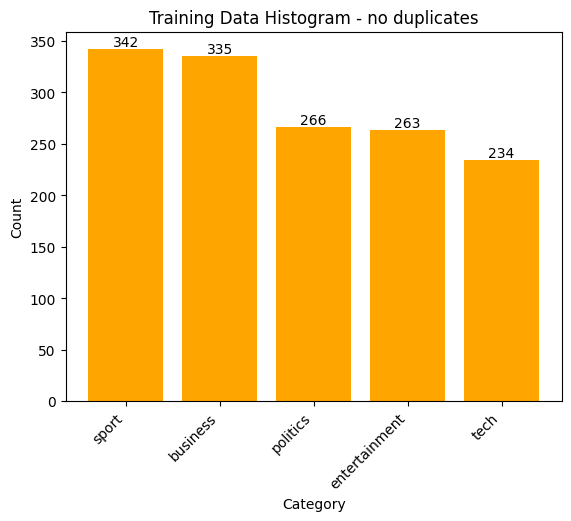

In [ ]:
# Remove duplicates
train = train.drop_duplicates(subset=['Text'])

# Check train data counts. Originally training data has 1490 rows and 50 rows should be dropped. So, I expect 1440 rows left.
print(f'Samples in training data after moving duplicates: {train.shape[0]}')

# Let's look at the histogram for 'Category' again
category_counts = train['Category'].value_counts()
plt.bar(category_counts.index, category_counts, color='orange')
plt.title('Training Data Histogram - no duplicates')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Category')
plt.ylabel('Count')
for i, count in enumerate(category_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()

We now have no duplicated values and also no null values. All data types look good. We are ready to do some more data preprocessing mainly specific to process text type of data.


# <a id="6"></a>
## Part 1.4: Data preprocessing for NLP
Text data usually need some specific "treatments". In most cases, we cannot just treat the whole document as a feature and do prediction. We need to transform each document to some sort of [feature vectors](https://en.wikipedia.org/wiki/Feature_(machine_learning)#Feature_vectors) with numeric values. There are many ways to do this. I will use **TFIDF** as described in [this article](https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification).

#### TFIDF
**TFIDF basics:** <br>
When a word (for example "game") appears many time in one document. It may indicate that the document is about sports. In TFIDF, we define the number of times one word appears in a document as term frequency (**'TF'**). To start, term frequency is helpful because it shows how important or relavent a word is to a document or article.

But how about the word 'the'. It may appears many times in any document too. TFIDF uses inverse document frequency (**'IDF'**) to deal with this. 'IDF' is the log (# documents / # of document with term). So, if the word 'the' appears in all documents, it has 'IDF' of 1 here. If 'game' appears in 30% of documents, it has a weight of log(100/30), which is around 1.2 here. So basically, less frequent word 'game' has a great weight ('IDF') here.

Note TFIDF **doesn't care about the sequence of words** (which can be very useful for conveying the meaning of sentences) but only presence of words. This is one of the [bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) model text data features extraction.

**Other things to consider of TFIDF:** <br>
- **tokenization**: As with most document/text to feature vector methods, to create feature vectors for each documents, we first need to tokenize the string to list of words. So we can learn each word an let each word add their part to the feature vector. For example, 'that is my job' can be tokenized to ['that','is','my','job']. Note for [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) in sklearn, the model can take care of this part so we could just enter the whole document as a string.
- **document length**: A word appear 3 times in a length of 500 words documents isn't the same as a word appear 3 times in a length  of 20 words document. So, if the lengths of documents are very different, we may need to normalize this. One way is to divide TFIDF by document length.
- **stemming**: To illustrate, the word 'game','games','gaming'are essentially the same. We don't want to treat them differently. Stemming help to deal with situations like this by those similar words to the same one. We will do some stemming along with TFIDF.
- **n grams**: "Golden State Warriors" isn't the same as "Golden", "Gate", and "Warriors". Depends on the text corpus, we may need to do some n grams to perserve the meaning of several words together. For instant, a 3-gram would look at all 3 words "Golden State Warriors" together.
- **stop words**: Lots of English word don't convey meanings. (For example, 'such', 'that', 'the', 'their', 'then', 'there', and'these'.) I think because TFIDF has the "IDF" part to degrade the frequent words (as explain previously), TFIDF can somehow deal with stop words. However, it's still good just to remove them before processing feature vectors.
- **maximum and minimum document frequency**: In additioanl to stop words, if a word appears in too many documents, it may not be a good predictor. Similarly of a word apppear in too few documents. But it depends on the model we use.
- **lower cases**: We don't want treat upper and lower case differently. So, usually we make all words lower case.
- **punctuations**: Punctuation can sometimes be helpful. For example, a period "." can indicate the end of a sentence. It might be useful for sequential NLP models but for TFIDF, we don't care about sequence. We care only about how frequent a relavent word appear in a documents (with adjustments such as IDF and document length). In another senario, a "!" may indicate an excitement. But for this project, we only care about the topics of the document. I plan to remove all punctuations for this project.
- **numbers**: Numbers would be treated as different "words" so it could add many more dimensions and cause overfitting. It's sometimes good to remove all numbers as well. But it depends on the data (are numbers frequent in documents?), the project goal (are numbers help with prediction?) and the later model we use. I'll discuss this later.
- **Hyperlinks and others**: Other things like 'hyperlinks' sometimes need to be removed. But sometimes they have good informations.

# <a id="7"></a>
### 1.4.1 Text documents EDA
First I want to dive in and do some analysis of the texts.



#### What do documents look like?

In [ ]:
# Take a look waht texts for each 'Category' looks like
print('sports text example:\n ',train[train['Category']== 'sport']['Text'].iloc[0],'\n')
print('business text example:\n ',train[train['Category']== 'business']['Text'].iloc[0],'\n')
print('politics text example:\n ',train[train['Category']== 'politics']['Text'].iloc[0],'\n')
print('entertainment text example:\n ',train[train['Category']== 'entertainment']['Text'].iloc[0],'\n')
print('tech text example:\n ',train[train['Category']== 'tech']['Text'].iloc[0],'\n')

sports text example:
  wales silent on grand slam talk rhys williams says wales are still not thinking of winning the grand slam despite a third six nations win.   that s the last thing on our minds at the moment   said williams  a second- half replacement in saturday s 24-18 win over france in paris.  we all realise how difficult a task it is to go up to scotland and beat them.  we ve come unstuck there a couple of times recently so our focus is on that game and we ll worry about ireland hopefully after we ve beaten scotland.  with captain gareth thomas ruled out of the rest of the campaign with a broken thumb  williams is vying for his first start in the championship so far.  kevin morgan is probably favourite to replace thomas at full-back  leaving williams and hal luscombe to battle for the right wing berth. a hamstring injury denied luscombe the opportunity to make a third successive start  but the dragons winger is expected to be fit for the trip to murrayfield on 13 march. hooke

#### What are some most frequent words?

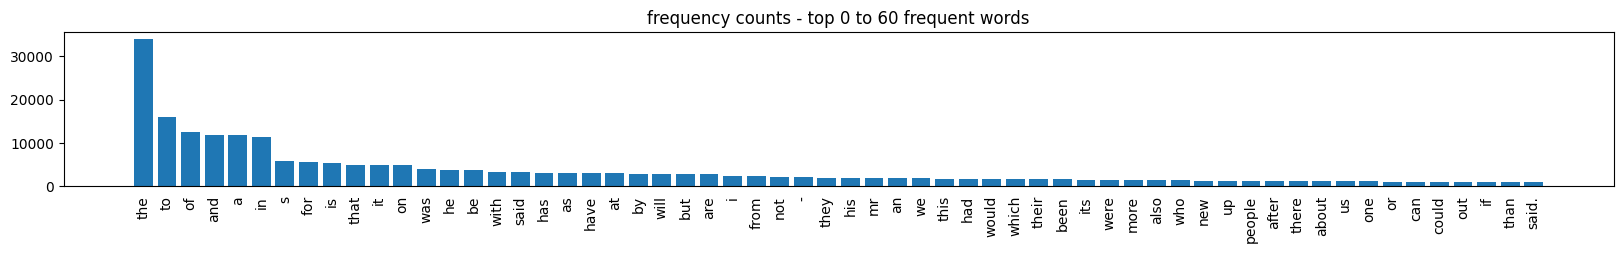

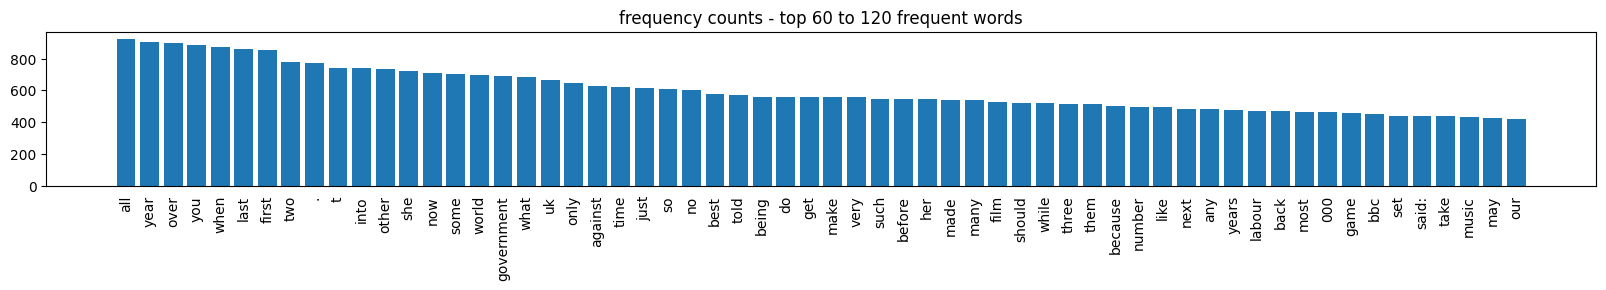

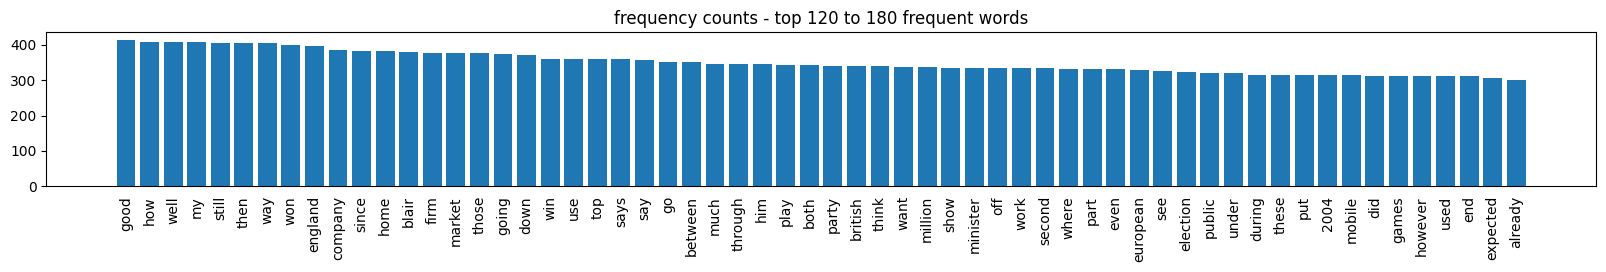

In [ ]:
# plot some most frequent words
def frequency_plot(frequency,start,end):
    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency)
    plt.title(f'frequency counts - top {start} to {end} frequent words')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency = train['Text'].str.split().explode().value_counts()

frequency_plot(frequency,0,60)
frequency_plot(frequency, 60,120)
frequency_plot(frequency, 120,180)

#### Thoughts on sample text output and the most frequent words
- **The most frequent words might not be the most "useful" ones.** <br>
From the graphs above, we can see there aren't many 'meaningful' words to predict topics. In the first 60 frequent words, most words aren't useful for prediction except maybe word like "people". The 60 to 120 most frequent words are still not very helpful except a few words like "government", "film","labour","music". The 120 to 180 most frequent words show more 'useful' words like "win","company","firm", "market", "win","party","minister","election","public","games","mobile". **Removing stop words** woudl be helpful. Also, TFIDF has this **IDF** part to add more weights to less frequent words.
- **Some words are similar but are treated differently** <br>
For example, "game" vs. "games". They are basically the same. It's good if we can treat them the same. **stemming** would be used to solve this.
- We usually want all words to be **lower case** because we don't want to treat them as different ones. From the text output and frequecy tables above, it seems all words are already in lower case.
- Although it seems there were some attempt to remove the **puntuations** already, the period "." is in the top 60 to 120 most frequenct words. As discussed in TFIDF section above, I will remove all puntuations.
- I am not sure **numbers** would be good predictors for topics. May it appear more in business documents? I plan to use matrix factorization, which would extract information from similar 'words' in this case (for example, all numerical values might reduced to a feature like "is_numerical") and reduce the dimension, I plan to keep the numbers for now.





# <a id="8"></a>
### Part 1.4.2 Text preprocessing
Although I [sklearn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) provides lot of options to do text preprocessing such as converting words to lower cases, remove stop words, and etc. I want to do it seperately first just to see how things would look like after those steps.


In [ ]:
# function for text preprocessing
def text_preprocessing(df):
    """
    This function does in place replacement of data so it won't return anything
    """
    # convert to lower cases
    df['Text']=df['Text'].str.lower()

    # remove punctuation
    df['Text'] = df['Text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

    # remove stopwords
    stop_words = nltk.corpus.stopwords.words('english')
    df['Text'] = df['Text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))

    # remove extra spaces
    df['Text'] = df['Text'].apply(lambda doc: re.sub(' +', ' ', doc))

    # stemming
    porter_stemmer = PorterStemmer()
    df['Text'] = df['Text'].apply(lambda doc:  [porter_stemmer.stem(word) for word in word_tokenize(doc) ])
    df['Text'] = df['Text'].apply(lambda words: ' '.join(words))

# take a look at text 0
train_copy = train.copy()
print('1st text before preprocessing: \n',train_copy['Text'][0])
text_preprocessing(train_copy)
print('\n1st text after preprocessing: \n',train_copy['Text'][0])

1st text before preprocessing: 
 worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and pr

It seems now after those preprocessing, all words are 'clean'.

Out of curiosity, let's plot some graphs to show most frequent words again. This time, I want to see top 60 frequent words in each category.

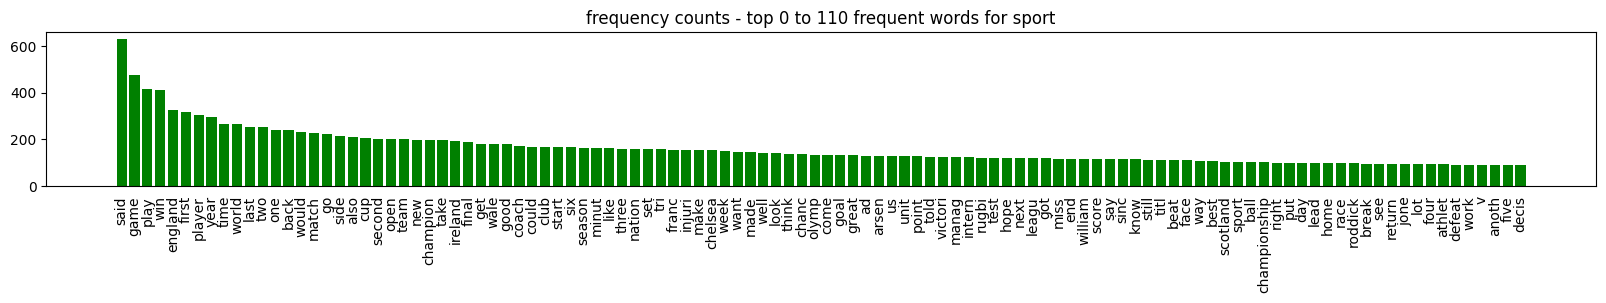

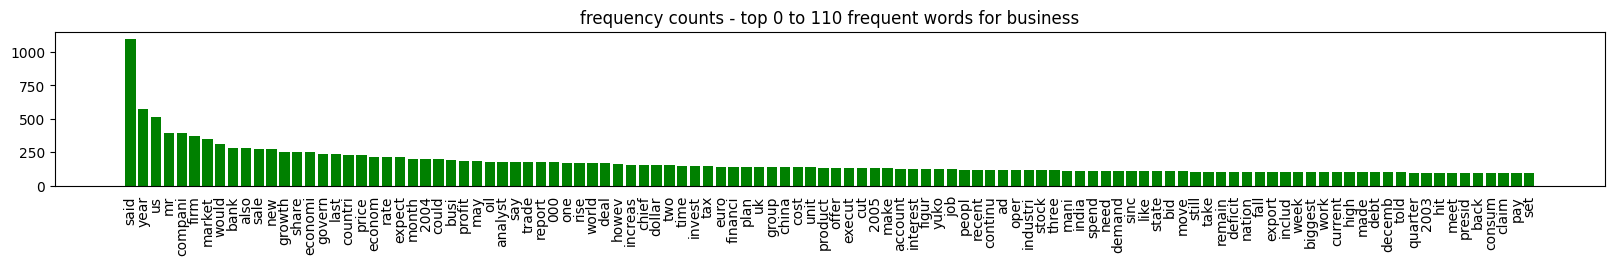

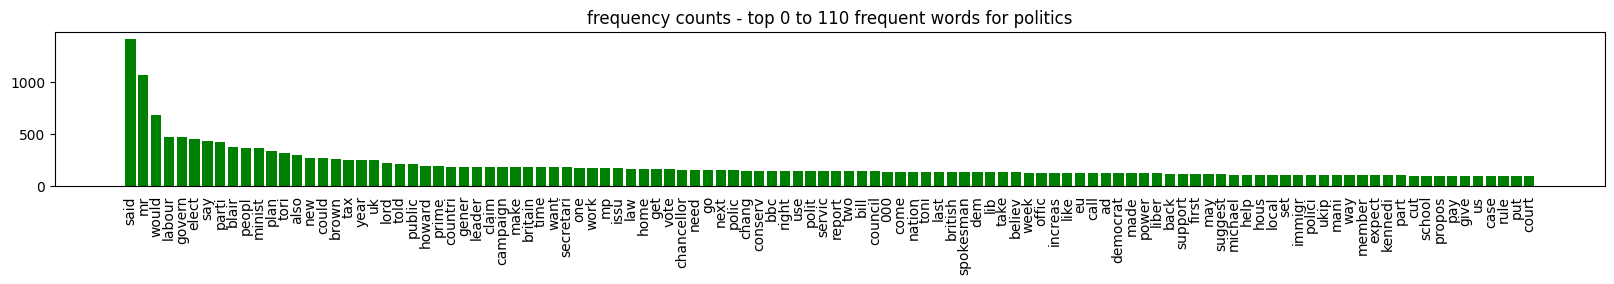

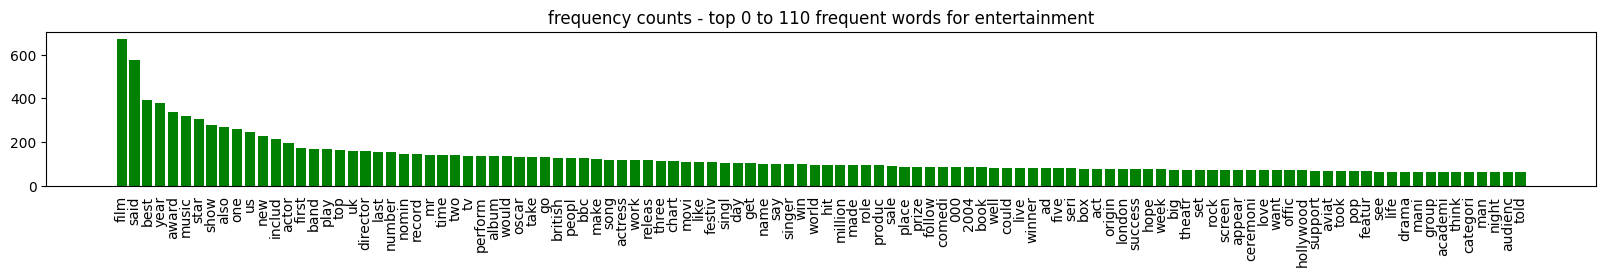

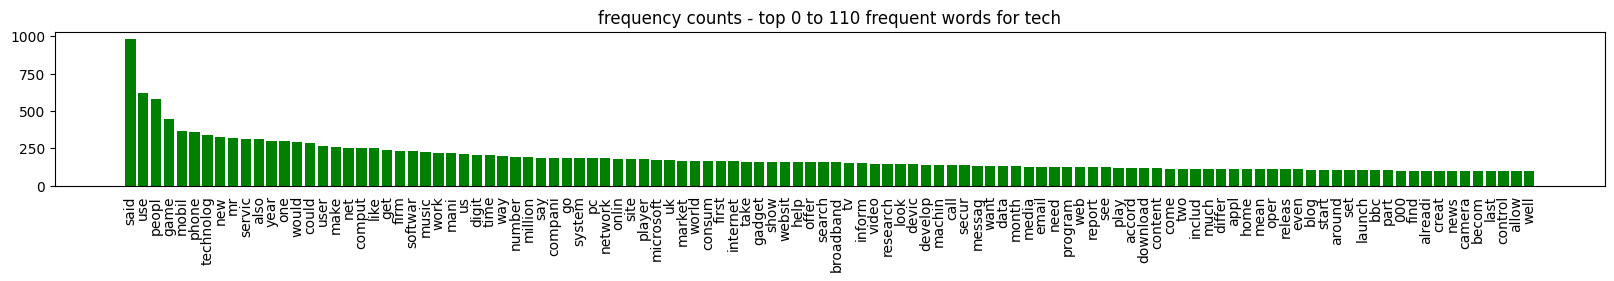

In [ ]:
# plot top 110 frequent words in each category after some word preprocessing
def frequency_plot(df ,start,end, Category):
    df_topic=df[df['Category']== Category]
    frequency = df_topic['Text'].str.split().explode().value_counts()

    frequency = frequency[start:end]
    plt.figure(figsize=(20,2))
    plt.bar(frequency.index, frequency, color = 'green')
    plt.title(f'frequency counts - top {start} to {end} frequent words for {Category}')
    plt.xticks(ticks=frequency.index,rotation=90, labels=frequency.index)
    plt.tick_params(axis='x', which='both', bottom=False, top=False)
    plt.show()

frequency_plot(train_copy,0,110,'sport')
frequency_plot(train_copy,0,110,'business')
frequency_plot(train_copy,0,110,'politics')
frequency_plot(train_copy,0,110,'entertainment')
frequency_plot(train_copy,0,110,'tech')

#### How data look like after text preprocessing?
After text preprocessing, I think the top frequent words makes more sense now. For example, "game","play","win",and "England" is among top 5 frequent words.

However, some words still appear a bit **too common and appear as top words across all 'Category' documents**. For example, **"said"** is the top 1 words for all category except entertainment. I believe TFIDF would somehow take care of it because "said"is probably in most documents but it may still affect the model performance. It's a good idea to remove it. Also, words like **"would", "also"** may need to be removed also. I would try this during later sklearn TFIDF modeling. Also, sklearn [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) has the parameter **max_df** which can set the maximum portion a word can appear across documents (and also min_df which set the minimum document a word can appear in documents). This would help with this issue.

#### Document lengths
As mentioned before, if the documents have very different lengths, we might need to do nomalilzation (divide TFIDF by document lengths). Let's dive into this.

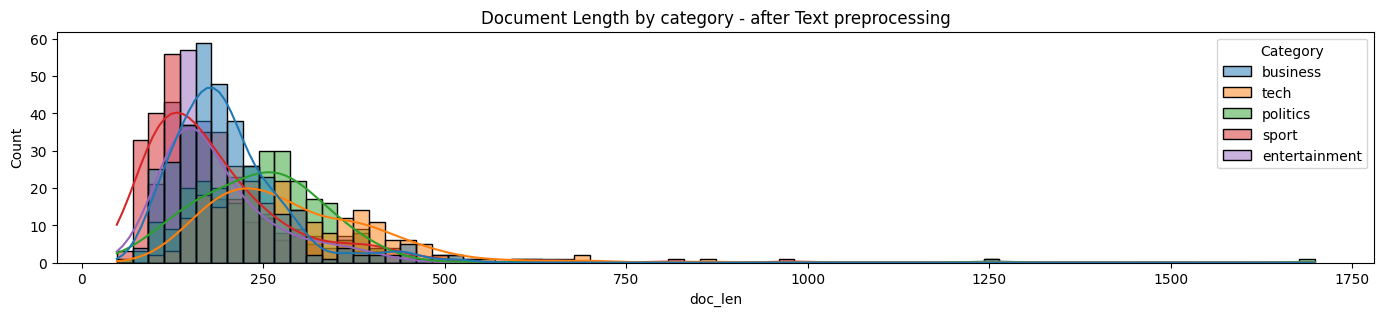

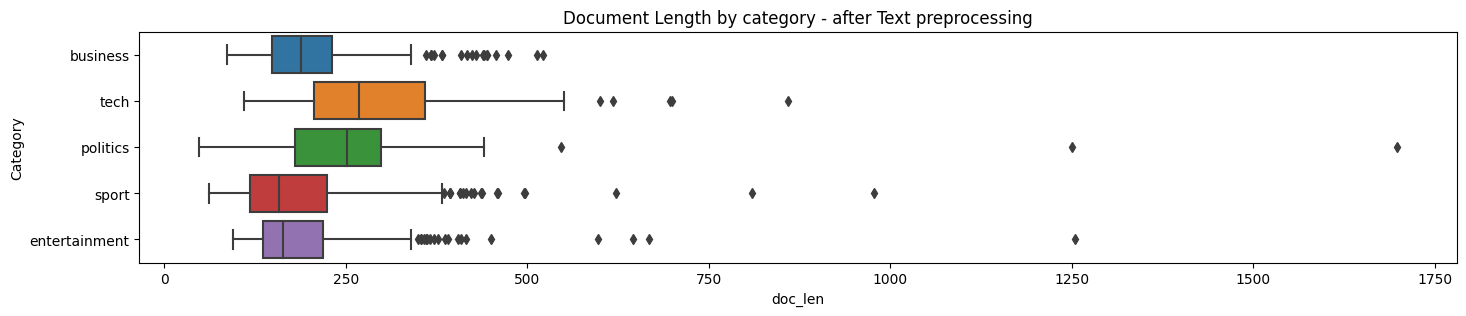

In [ ]:
# Take a look at document lengths

# Get document lengths
train_copy['doc_len'] = train_copy['Text'].apply(lambda words: len(words.split()))

# Historgram by category
fig, ax = plt.subplots(figsize=(17, 3))
sns.histplot(
    data = train_copy,
    x = 'doc_len',
    kde=True,
    hue = 'Category'
    ).set(
        title = 'Document Length by category - after Text preprocessing');

# boxplot by category
fig, ax = plt.subplots(figsize=(17, 3))
sns.boxplot(
    data = train_copy,
    x = 'doc_len',
    y = 'Category',

    ).set(
        title = 'Document Length by category - after Text preprocessing');

It does seem document lengths vary a bit. It seems there are some long tails especially for politics and entertainment. And also, tech seem to have longer documents while business and entertainment have shorter documents overall. Those would affect predictions. I will do **normalization** when model TFIDF.

# <a id="9"></a>
# Part 2: Matrix Factorization training and predictions

#### What is a matrix factorization model
Matrix factorization is usually a method for recommend system. It's one kind of collaborative filtering (need user-user or item-item relationship) under latent factor models. The motivation is that the rating matrix (for example user-movie rating matrix) can be a very sparse (one user may only watch very small portion of movies) and overfit representation of the user tastes. Also, with hugh number of both users and items, the rating matrix is usually extremely expensive to store and do any computation (thinking about computing user-user or item-item similarity for each possible pairs!).

With the beauty of linear algebra, we can factorize any (m * n) dimension matrix by (m * d)*(d * d)*(d * n) matrix using singlar value decomposition. Here, d is the latent factors, and d<<m or n (so those matrix need way less storage room). Assuming (m * n) is a user-rating matrix, m*d would be a user-latent factor matrix. (d * d) would be a diagonal matrix, by absolute value, it can represent how important that latent factor (or dimension) is. (d * n) would be an item-latent factor matrix. We can then choose k most important latent factors. That way we would have 3 matrix of (m * k),(k * k),and (k * n) dimensions. Note because of the property of singular value decomposition, each latency factor are independent (no correlations)! So, the latent factor features created are very good feature vectors. (Unlike movie rating as features, for example 'Titanic' and 'The Notebook' can share similarity as a romantic movie). Also, to get ith user's preference of jth item, we could just multiply ith user's row in (m * k) by(d * d),and by jth item's column of (k * n). Cheap to compute!


We can also add constrains the matrix factorization model for better results. For example, for this project, since the word frequency count should always be positive. I would use [non-negative matrix factorization model](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) from sklearn.

Note for this project, we don't need to do recommendation. We would only care about m and d, in which m is the documents (or articles) and the latent factor d is the 5 categories we want to 'predict'. So, we want to transform the documents-words matrix to documents-catogories matrix.


#### Unsupervised learning for a supervised learning problem? Why and How?
In real life, labeled data can be precious commodity. In those cases when there is a small number of labels or no labels, unsupervised learning can be powerful.

How to do it? After running an unsupervised learning model, we would have some labels. In unsupervised learning, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. One way is that we can map those unsupervised labels to ground true labels choosing best mapping based on performance (for example, based on accuracy).

The function predict (which I should probably call 'label_permuation' instead) below would help to to find the best matching label ordering based on the accuracy.

#### When we train the unsupervised model for matrix factorization, should we include texts (word features) from the test dataset or not as the input matrix? Why or why not?
Since matrix factoraization is an unsupervised learning model, we don't need labels to train. It might seems to enhance the testing accuracy if we include texts (word features) from the test dataset as input matrix in training. **This practice should be strictly avoided!** For model training and predictions, it's very important to split training and testing set and not let model see any part of testing data while training. (For this project, the data is already splitted. )

The reason is that we want to train and choose the model that **generalize well** so it perform best on **unseen data**. The model performance on testing data can sort of give us some idea of that so we can choose the best model. Including testing data in training will lead to misleading results.

If we include any sort of testing data while we do training, the model performance on testing doesn't really tell us how the model would perform on unseen data, which is the most crucial to look at. We would ended up choosing a model that aim to fit all "seen" data (including test) as good as possible but neglect the important part to generalize well on unseen data. It's called double dipping. The 'best' model we ended choosing would certainly be **overfitting**. It won't be the model that would be generalized enought to fit well on unseen data (although it might seem to have a great 'testing data' performance). Note overfitting occurs when the model fit too closely to seen data so it loose a bit of generalization to perform well on real-world, unseen data.


# <a id="10"></a>
## Part 2.1 label permutations and mapping

In [ ]:
# Label Permutation
def predict(df,yp, n=5,label_portion=1): #should probably call this function label_permutation but let's leave it as it is for now
    """
    input
    df: DataFrame
    yp: dimension (1440 *5). training size (no dup) * class. It's in indices order already from call in NMF output!! numpy format,
    n: number of labels. (would always to 5 for this project). integer

    return
    best_ypred: list of predication using permutation that produce best accuracy, note it's in indices order!! list format
    best_label_mapping_yp: dictionary that map unsupervise learning labels to ground truth labels, dictionary format
    best_accuracy: accuracy from permutation that produce best accuracy, list format, float format
    """
    # labeled sample size
    #yt
    yt=df['Category']

    if label_portion != 1:
        np.random.seed(1)
        sample_size = int(label_portion * df.shape[0])
        rows = np.random.choice(np.arange(df.shape[0]), sample_size  )
        yt=yt.iloc[rows]

    # yp transfer
    yp = np.argmax(yp, axis=1) # Now yp is np array also

    if label_portion !=1:
        yp= yp[rows]

    # intialize several parameters
    best_accuracy=float('-inf')
    best_permutation=()
    best_label_mapping_yp = {}
    best_ypred=[]
    permutations=list(itertools.permutations(np.arange(n))) # a list of size n tuples

    # get actual 'Category' ['business', 'tech', 'politics', 'sport', 'entertainment']
    unique_labels= yt.unique()

    # map 'numerical labels' to 'Category': Ex:  {0: 'business', '1: 'tech', 2: 'politics', 3: 'sport', : 'entertainment'}
    label_mapping_yt = {i: label  for i,label in enumerate(unique_labels)}

    for permutation in permutations:
        label_mapping_yp = {perm:  label_mapping_yt[i]  for  i,perm in enumerate(list(permutation))}
        yp_gt = [label_mapping_yp[y] for y in yp] # transfer to ground truth label
        accuracy = (yt==yp_gt).sum()/len(yt)
        # update to keep the best accuracy permutation
        if accuracy> best_accuracy:
            best_permutation = permutation
            best_accuracy=accuracy
            best_ypred = yp_gt
            best_label_mapping_yp = label_mapping_yp

    return (best_ypred ,best_label_mapping_yp, best_accuracy)

# <a id="11"></a>
## Part 2.2 Model trainings and predictions (First Try)

In [ ]:
# Function for NMF training
def MF_training(df, min_df=0.0, max_df = 1.0, norm='l1', stop_words = None, ngram_range= (1,1), l1_ratio =0.0, label_portion =1 ):
        """
        This function is for NMF training. It has text preprocessing, tfidf, and NMF.

        Input:
        df: df is training data. df has default size to be the same size of training data (minus duplicates). Data frame format.
        label_portion: portions of labels for label permutation. Can set to be less than 1 for NMF but has to be 1 for supervised model. float format

        return:
        y_pred_train_labeled_data: list of predications only on labeled data! list format
        label_mapping_yp: dictionary that map unsupervise learning labels to ground truth labels, dictionary format
        tfidf, nmf: trained models
        accuracy: accuracy only on labeled data (so for NMF, if we include 1% of labels. the accuracy is only those small part of labeled data)!! float format

        """
        # Text preprocess
        text_preprocessing(df)

        # TFIDF model
        tfidf = TfidfVectorizer(
                                 min_df = min_df,
                                 max_df = max_df,
                                 norm = norm,
                                 stop_words =stop_words,
                                 ngram_range = ngram_range)
        tfidf_train = tfidf.fit_transform(df['Text'])

        # NMF model
        nmf = NMF(n_components=5,
                        init='nndsvda',
                        solver = 'mu',
                        beta_loss = 'kullback-leibler',
                        l1_ratio = l1_ratio,
                        random_state = 1)
        nmf_train = nmf.fit_transform(tfidf_train) #nmf_train is a np array of dimension (1440*5)

        # Transform unsupervised learning labels to ground truth labels
        y_pred_train_labeled_data , label_mapping_yp , labeled_data_accuracy = predict(df=df, yp=nmf_train, label_portion=label_portion)

        print(f'training accuracy on labeled portion ({label_portion}) of data is:', labeled_data_accuracy)

        return labeled_data_accuracy, tfidf, nmf, label_mapping_yp, y_pred_train_labeled_data # accuracy, y_pred_train is only on labeled data!!!


In [ ]:
# function to predict testing data
def predict_data(df,tfidf, nmf, label_mapping_yp ):
    # predict testing data
    text_preprocessing(df)
    tfidf = tfidf.transform(df['Text'])
    nmf = nmf.transform(tfidf)
    y_pred = np.argmax(nmf, axis=1)
    y_pred = [label_mapping_yp[y] for y in y_pred]
    return y_pred

# function to submit results
def submit_result(y_pred_test):
    test_pred = pd.DataFrame(columns=['ArticleId', 'Category'])
    test_pred['ArticleId'] = test['ArticleId']
    test_pred['Category'] = y_pred_test

    #save and submit test dataframe
    try:
        test_pred.to_csv('submission.csv', index=False)
    except:
        pass


In [ ]:
# Training with the model (first try with no tuning)
train_copy = train.copy()
train_accuracy, tfidf, nmf, label_mapping_yp, ypred_train_no_tune = MF_training(train_copy, label_portion =1)

training accuracy on labeled portion (1) of data is: 0.9291666666666667


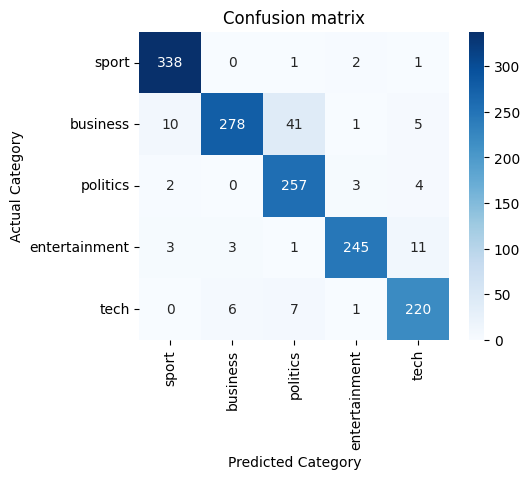

In [ ]:
# Since the data isn't perfectly balanced. Let't take a look at the confusion matric.

# Confusion matrix function
def plot_conf_matrix(yt, yp, label_order= ['sport','business','politics','entertainment','tech'] ):
        cfm = confusion_matrix(yt,yp,labels =label_order)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cfm, annot=True, fmt='.0f',cmap='Blues',xticklabels=label_order, yticklabels=label_order)
        plt.xlabel('Predicted Category')
        plt.ylabel('Actual Category')
        plt.title('Confusion matrix')
        plt.show()

# Plot
plot_conf_matrix(train['Category'],ypred_train_no_tune )

Confusion matrix on training data doesn't look too bad except lots of business doc were classified as politics. Just keep this in mind for now. Let's submit the first round of results with no model tuning.

In [ ]:
# Train testing data and submit the results
# test_copy = test.copy()
# y_pred_test =  predict_data(test_copy,tfidf, nmf, label_mapping_yp )
# submit_result(y_pred_test)

#### After submission, the testing score was 0.95102 before any tuning. 😉 Surprisingly not bad!

# <a id="12"></a>
## Part 2.3 Model Tuning
A test performance of 0.95102 isn't too bad before tuning. Let's how it perform after some tuning. Honestly, I've already did a few tuning before the model below so I've chosen the better ones below already. I don't want to include those in my final reports because it would take too long to run. So, the model below is more like a 'fine' tuning. :)


In [ ]:
# Model tuning
def model_tuning(data, test_size= 0.2):
    """
    data: data frame format
    test_size: size of validation set, float format:
    """

    # initilize besties
    best_accuracy=float('-inf')
    best_pred_train = []
    best_pred_test =[]
    best_mindf = None
    best_maxdf = None
    best_sw=[]
    best_norm = None
    best_ngram_range = ()
    bestl1_ratio = None
    best_tfidf = None
    best_NMF = None

    # training and testing accuracies
    training_acc =[]
    testing_acc = []

    # Split data
    X, y = data.drop(['Category'], axis=1), data['Category']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_size, random_state=10)
    X_train_df = pd.DataFrame(X_train, columns=X.columns)
    y_train_df = pd.DataFrame(y_train, columns=['Category'])
    X_train_df = pd.concat([X_train_df, y_train_df], axis=1)

    # Preprocessing
    text_preprocessing(X_train)
    text_preprocessing(X_test)

    # Try different parameters
    for min_df in [2,10]:
        for max_df in [0.8, 0.9, 0.95]:
            for norm in ['l1','l2']:
                for stop_words in [["said","would", "also"],None]:
                    for ngram_range in [(1,1),(1,2)]:
                        for l1_ratio in [0.4, 0.5]:
                                    tfidf = TfidfVectorizer(min_df = min_df,
                                                           max_df = max_df,
                                                           norm = norm,
                                                           stop_words =stop_words,
                                                           ngram_range = ngram_range)
                                    tfidf_train = tfidf.fit_transform(X_train['Text'])
                                    nmf = NMF(n_components=5,
                                            init='nndsvda',
                                             solver = 'mu',
                                              beta_loss = 'kullback-leibler',
                                              l1_ratio = l1_ratio,
                                              random_state = 1)
                                    nmf_train = nmf.fit_transform(tfidf_train)

                                    # Transform unsupervised learning labels to ground truth labels and get accuracy
                                    y_pred_train , label_mapping_yp , accuracy = predict(X_train_df, nmf_train)
                                    training_acc.append(accuracy)

                                    # predict testing data
                                    tfidf_test = tfidf.transform(X_test['Text'])
                                    nmf_test = nmf.transform(tfidf_test)
                                    y_pred_test = np.argmax(nmf_test, axis=1)
                                    y_pred_test = [label_mapping_yp[y] for y in y_pred_test]
                                    test_accuracy = accuracy_score(y_test, y_pred_test)
                                    testing_acc.append(test_accuracy)
                                    print(f'min_df: {min_df}, max_df: {max_df}, tfidf norm: {norm}, stop_words: {stop_words}, ngram_range: {ngram_range}, l1_ratio: {l1_ratio},train_accuracy:  {accuracy}, test_accuracy: {test_accuracy}')

                                    # update besties
                                    if test_accuracy > best_accuracy:
                                                    best_accuracy=test_accuracy
                                                    best_pred_train = y_pred_train
                                                    best_pred_test = y_pred_test
                                                    best_mindf = min_df
                                                    best_maxdf = max_df
                                                    best_sw=stop_words
                                                    best_norm = norm
                                                    best_ngram_range = ngram_range
                                                    bestl1_ratio  = l1_ratio

    print(f'best_accuracy: {best_accuracy},best_max_df: {best_mindf}, best_maxdf: {best_maxdf}, best_sw: {best_sw}, best_norm: {best_norm}, best_ngram_range: {best_ngram_range}, bestl1_ratio: {bestl1_ratio}')

    return (best_tfidf,best_NMF, best_pred_train, best_pred_test, training_acc, testing_acc )

In [ ]:
# Let's take a look at the tuning result
train_copy = train.copy()
tfidf_2, nmf_2, best_pred_train, best_pred_test, training_acc, testing_acc = model_tuning(train_copy, test_size=0.2)

min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 1), l1_ratio: 0.4,train_accuracy:  0.9505208333333334, test_accuracy: 0.9305555555555556
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 1), l1_ratio: 0.5,train_accuracy:  0.9505208333333334, test_accuracy: 0.9305555555555556
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 2), l1_ratio: 0.4,train_accuracy:  0.9661458333333334, test_accuracy: 0.9548611111111112
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: ['said', 'would', 'also'], ngram_range: (1, 2), l1_ratio: 0.5,train_accuracy:  0.9661458333333334, test_accuracy: 0.9548611111111112
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: None, ngram_range: (1, 1), l1_ratio: 0.4,train_accuracy:  0.9496527777777778, test_accuracy: 0.9305555555555556
min_df: 2, max_df: 0.8, tfidf norm: l1, stop_words: None, ngram_range: (1, 1), l1_ratio: 0.5,tra

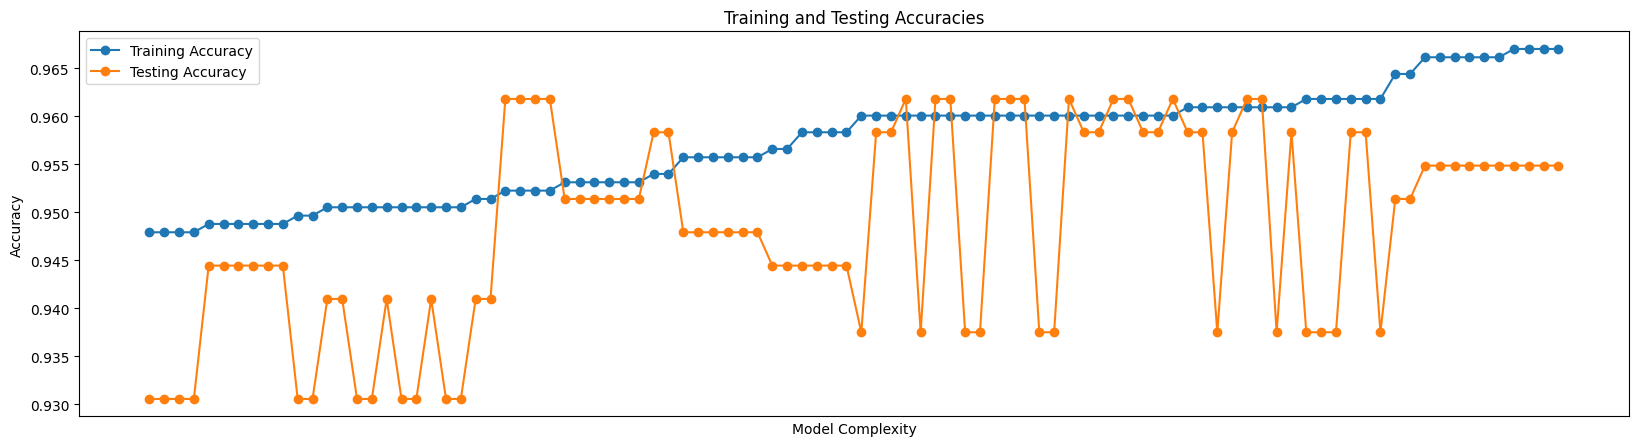

In [ ]:
# Graph training vs. testing accuracy

# First I want to sort the training accuracy
sorted_indices = np.argsort(training_acc)
training_acc = np.array(training_acc)[sorted_indices]
testing_acc = np.array(testing_acc)[sorted_indices]

# Now let's graph
runs = list(range(1, len(training_acc) + 1))
plt.figure(figsize=(20,5))
plt.plot(runs, training_acc, label='Training Accuracy', marker='o')
plt.plot(runs, testing_acc, label='Testing Accuracy', marker='o')
plt.xlabel('Model Complexity')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()
plt.xticks([])
plt.show()

#### What do I think of the tuning output and results?
While it's hard to be sure which parameter is totally better since there are several paramenters tuned at the same time, it's more about combinations. A few things I may find (but it's all 'in general'):
- ngram_range (1,2) seems to fit a bit better better than (1,1). I did try (1,3) (although now shown here), it's not good either.
- Adding additional stop words **['said','would','also']** maynot hurt the performance, but it's not obviously better. (Note we've already removed 'english' stop_words in text preprocessing.). I guess the reason is that we have min_df, and max_df to help with that. Also, we human can't easily see but although those words appear in different categories but their TFIDF could be very different (especially combine with n-grams). Those could help with predictions?
- When training accuracy is too high, the model clearly starts to overfit. The maximum testing accuracy (0.9618) occur in a range of training accuracy then it start to drop. In  that range, the testing accuracy isn't stable (has 3 different values).
- One thing a bit wierd is that when the best testing performance happens (0.9618), the training accuracry (around 0.9601 or 0.9523) are all a bit lower than testing. 🧐 I feel it could be a sign that there are a bit of some outliers that hurt the performance in the training data. Or, it just happened😅 that the testing part of data is a bit easier to predict with certain model.
- Next, I want to re-train the model with all my training data. Note since there are several best models here, I want to choose the one I think might be the most general (simple). To do that,I first want to choose the one with the lowest training accuracy (0.9523). Then, I choose no set of extra stop words, set the max_df to be 0.95 (instead of 0.8), set the min_df to be 2 (instead of 10) so the model wouldn't exclude any extra words if not too helpful. I've tried a few and it seems this combination produce the best testing accuracy.

In [ ]:
# Let's re-train all training data again use the best parameters
train_copy = train.copy()
train_accuracy, tfidf, nmf, label_mapping_yp, ypred_train  = MF_training(train_copy, min_df=2, max_df=0.95,  norm='l2', ngram_range= (1,2), l1_ratio =0.5)

training accuracy on labeled portion (1) of data is: 0.95


Next, let use the [chi-squared test](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test) to find the most correlated terms with the categories with the best tfidf model!

In [ ]:
# Use chi-squresd squred test to see the most correlated term in each category
feature_vecs = tfidf.fit_transform(train_copy['Text']).toarray()
print(feature_vecs.shape)
print(len(feature_vecs))
print(label_mapping_yp)

N = 5
for label_id, category in label_mapping_yp.items():
    chi2_corr = chi2(feature_vecs,  train_copy['Category'] == category)
    indices = np.argsort(chi2_corr[0])
    fv_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in fv_names if len(v.split(' ')) == 1]
    bigrams = [v for v in fv_names if len(v.split(' ')) == 2]

    print(f"** {category}:")
    print("  . Top 5 correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Top 5 correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

(1440, 44899)
1440
{2: 'business', 4: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}
** business:
  . Top 5 correlated unigrams:
       . economi
       . profit
       . oil
       . growth
       . bank
  . Top 5 correlated bigrams:
       . analyst said
       . oil price
       . stock market
       . econom growth
       . interest rate
** tech:
  . Top 5 correlated unigrams:
       . technolog
       . softwar
       . user
       . phone
       . mobil
  . Top 5 correlated bigrams:
       . let peopl
       . music player
       . mac mini
       . search engin
       . mobil phone
** politics:
  . Top 5 correlated unigrams:
       . parti
       . tori
       . blair
       . elect
       . labour
  . Top 5 correlated bigrams:
       . mr howard
       . prime minist
       . lib dem
       . mr brown
       . mr blair
** sport:
  . Top 5 correlated unigrams:
       . chelsea
       . england
       . match
       . champion
       . cup
  . Top 5 correlated bigrams:
  

Dimension reduction is a good way to visualize high-dimensional features. When the features are reduced to 2 dimensions, it's easier to visualize and see some pattern or trends.

Principal Component Analysis (PCA) is one popular method. For NLP,  [**t-SNE**](https://lvdmaaten.github.io/tsne/), get used more.

Next, let's see how those 5 cateogory features are in 2-D using t-SNE.

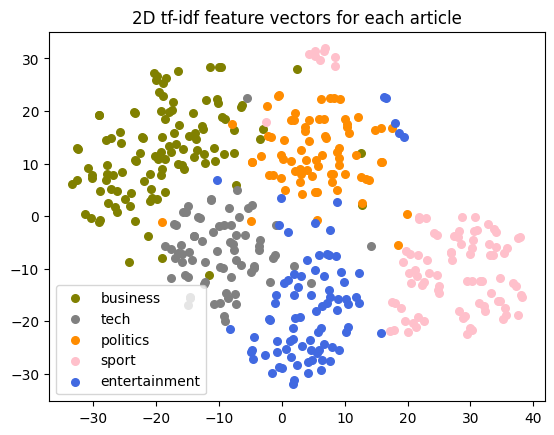

In [ ]:
# t-SNE for feature vector visualization

# Choose subset of features (because t-SNE is computationaly expensive)
sample_size = int(len(feature_vecs) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(feature_vecs)), size=sample_size, replace=False)

# t-SNE
lowd_features = TSNE(n_components=2, random_state=1).fit_transform(feature_vecs[indices])
colors = [ 'pink', 'darkorange','olive', 'royalblue', 'gray',]
for label_id, category in label_mapping_yp.items():
    points = lowd_features[(train_copy['Category'].iloc[indices]== category).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[label_id], label=category)
plt.title("2D tf-idf feature vectors for each article")
plt.legend()

How interesting is the output! For the chi-squared correlation output, I can see why 2-gram works better. The paired word definitely seem to greatly correlate to the category.

From the 2-D tfidf, we can see there are clearly some clusterings of 5 categrories. However, expect some model performance bottle neck since there are some outliers and points in boundaries. Those points would either be misclassified in training data or drive the model to overfit (overlly complex model in order to fit those points).

Okay! Next, let's see a metric other than accuracy.

We've already decided the best model depends on the performance on validation set.

Now, after training the best model with training data, I know it's not most ideal thing to look at since with overfitting, training data performance isn't always a good prediction of testing data. For simplicity, let's just take a look at confusion matrix on model performance on training data to get a sense:

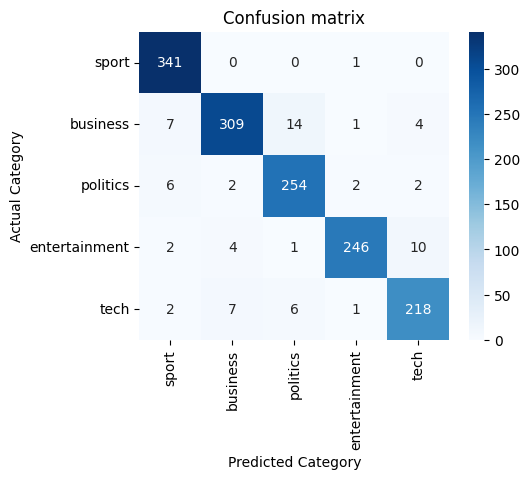

In [ ]:
# Plot confusion matrix on prediction on training data
plot_conf_matrix(train['Category'],ypred_train )

Seems the situation that the business docs are classified as politics docs improved a lot after tuning although it still has the highest error. This sort of make sense since business and politic docs can be similar to each other.

In other areas, I don't see very obvious improvement though (some even have high errors). For example, there are still lots of entertainment docs (from 11 to 10) being classified as tech. There are 6 politics doc classified as sport. Before tuning this was 2.

Also, there are still many docs are classified as sports when they aren't (precision isn't good) . But when for sports articles, they are classfied pretty well (high recall).I wonder if it's those docs are indeed difficult to distinguish.

But with the help of the 2-D tfidf graph, it might be good that the model actually mis-classified some points because some category points seem to be in other category clusters! We don't want the model to be too complex (overfit) in order to fit those outlier or difficult points.

In [ ]:
#  Let's predict the testing data and submit results after tuning and see how it goes
# test_copy = test.copy()
# y_pred_test = predict_data(test_copy,tfidf, nmf, label_mapping_yp )
# submit_result(y_pred_test)


#### After submission, the testing score was 0.96734 after tuning😄.
It's a bit better, which is expected from the improvement of the confusion matrix on training results. Note the testing accuracy is better than training accuracy. We probably don't have much of overfitting problem! Instead,there maybe 2 problems:
 - Maybe the model is a bit under-fitting? There are some outliers data in the training so that the best performance model (on validation set) we choose is a tidy bit too simple? If so, if we somehow reduce those outliers in the sample, the model can be trained to fit things better?
 - It's the natural of the problem that there would be just some categories mix with each other in NMF in both training and testing data. We really can't do much about them. From the 2-D tfidf above, I am afraid this can be the problem more or less.🥲

Let's find out next.

# <a id="13"></a>
## Part 2.4 Attempt to further model improvement (Ensemble approach)
As discussed above, there a sign that there are some outliers (or difficult ones) in the training data.

Thus, we can try an ensemble method here, which sampling portion of the data (without replacement) in each iteration and train several models. This way, we could let some models not seen some outliers. Then, we can use each model to predict the testing results and choose the 'cateogry' with the most votes as the final results. This is similar to bagging in Random Forest but bagging uses bootstrap, which do sampling with replacement. I've tried boostrap (code not shown in this project for simplicity) but it didn't perform worse. I guess the data isn't large enough.

I'll focus on sampling with no replacement for my ensemble method.


In [ ]:
def random_sample(data, size=1):
    """
    data: training data, DataFrame type
    size: <=1 positive, float type

    return
    bootstrap: data with random choice indices of a given size, DataFrame type
    indices: indices from random choices of a given size, numpy type
    """
    # Initialization
    samples = []
    sample_size = int(size * data.shape[0])

    # Get indices and get samples
    indices = np.random.choice(data.index, size=sample_size, replace=False)
    samples = data.loc[indices]

    return samples


In [ ]:
def train_ensemble(size=1, label_portion=1):
        """
        no need to input input data, it's only for training data (with no dup)
        size: (0,1], float type

        """
        # Get sample data
        train_copy = train.copy()
        sample_train = random_sample(train_copy, size= size) #indices are in numpy array type

        # Train best model with sample data
        train_accuracy, tfidf, nmf, label_mapping_yp, ypred_train  = MF_training(sample_train, min_df= 2/1440,max_df=0.95, norm='l2', ngram_range= (1,2), l1_ratio =0.5, label_portion=label_portion)

        # Predict all training data (not just labeled data) and testing data
        test_copy=test.copy()
        y_pred_all_train= predict_data(train_copy, tfidf, nmf, label_mapping_yp)
        y_pred_test =     predict_data(test_copy,tfidf, nmf, label_mapping_yp )
        return y_pred_all_train, y_pred_test

In [ ]:
# Now let's perform ensemble training
num_iterations = 5

# List to store y_pred_test results
y_pred_all_train_list = []
y_pred_test_list = []

# Loop to generate y_pred_test with different sizes
for i in range(num_iterations):
    np.random.seed(i)
    y_pred_all_train, y_pred_test = train_ensemble(size=0.95)  # Adjust the size as needed
    y_pred_all_train_list.append(y_pred_all_train)
    y_pred_test_list.append(y_pred_test)

training accuracy on labeled portion (1) of data is: 0.9437134502923976
training accuracy on labeled portion (1) of data is: 0.9510233918128655
training accuracy on labeled portion (1) of data is: 0.9510233918128655
training accuracy on labeled portion (1) of data is: 0.9466374269005848
training accuracy on labeled portion (1) of data is: 0.9502923976608187


In [ ]:
# aggregation function
def Agg_pred(pred_array):
            """
            The function will get y with most votes in iterations
            """
            stacked_array = np.vstack(pred_array)

            modes, counts = np.unique(stacked_array, axis=0, return_counts=True)

            most_frequent_indices = np.argmax(counts, axis=0)

            pred_list_ensemble= modes[most_frequent_indices]

            return pred_list_ensemble

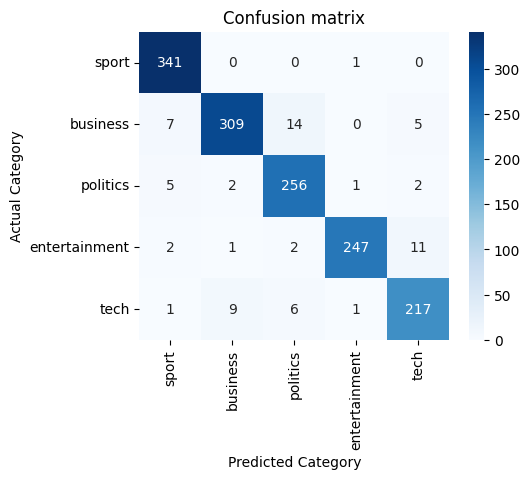

In [ ]:
# Let's look at how ensembled model does on all training data
y_pred_train_ensemble = Agg_pred( y_pred_all_train_list)
plot_conf_matrix(train['Category'], y_pred_train_ensemble )

# predict testing data and submit the results
# y_pred_test_ensemble = Agg_pred(y_pred_test_list)
# submit_result(y_pred_test_ensemble)

#### The testing submission results is exactly the same 0.96734 after my ensembling method😄. No improvement.
It could be we haven't run too many iterations so outliers are mostly in all training models.

Or, the data is just difficult (as we can see in 2-D tfidf graph) and we've done our best using TFIDF and Matrix Factorization!  We can see this a bit from the training data confusion matrix above. It's very similar to the previous one. It does seem the model is indeed struggling in some areas like business vs. politics. Since we use TFIDF, which only look at the frequency of words (with idf), I think because politics and business could share many similar words, TFIDF with NMF might hit a bottle neck.

I think it's good enough! Let's move on to the supervised learning.

# <a id="14"></a>

# Part 3: Comparison with a supervised model
Let's compare NMF with a supervised model - random forest. We will compare the performance on testing data, overfitting situation, and efficient use of labeled data.

An important note here is that we are comparing NMF and randome forest here. The comparison results can't represent all unsupervised learning and supervised leasrning model. For instance, **if NMF perform better here, it doesn't mean unsupervised model is better than supervised model in general for this project!**👌

# <a id="15"></a>
## Part 3.1: Random Forest training, prediction, and comparison with NMF

In [ ]:
# prepare training and testing data
train_copy=train.copy()
text_preprocessing(train_copy)
test_copy=test.copy()
text_preprocessing(test_copy)

# TFIDF model
tfidf = TfidfVectorizer( min_df = 2,
                        max_df = 0.95,
                        norm = 'l2',
                        stop_words =None,
                        ngram_range = (1,2))
tfidf_train = tfidf.fit_transform(train_copy['Text'])
tfidf_test = tfidf.transform(test_copy['Text'])

# random forest
rf= RandomForestClassifier()

# grid search for rf
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [20, 50],
    'min_samples_split': [10,20],
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(tfidf_train, train_copy['Category'])

# Get the best hyperparameters
best_params = grid_search.best_params_

# Get the best model
best_rf_model = grid_search.best_estimator_
print(grid_search.best_score_)
print(best_params)

0.954861111111111
{'max_depth': 50, 'min_samples_split': 20, 'n_estimators': 100}


In [ ]:
# Peek at some grid search results
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.491807,0.004204,0.037250,0.000563,20,10,50,"{'max_depth': 20, 'min_samples_split': 10, 'n_...",0.927083,0.922917,0.945833,0.931944,0.009967,8
1,0.991168,0.018827,0.066591,0.001026,20,10,100,"{'max_depth': 20, 'min_samples_split': 10, 'n_...",0.931250,0.943750,0.956250,0.943750,0.010206,5
2,0.443158,0.006952,0.036574,0.000302,20,20,50,"{'max_depth': 20, 'min_samples_split': 20, 'n_...",0.910417,0.943750,0.956250,0.936806,0.019345,7
3,0.872216,0.002625,0.065466,0.000721,20,20,100,"{'max_depth': 20, 'min_samples_split': 20, 'n_...",0.935417,0.945833,0.956250,0.945833,0.008505,2
4,0.660691,0.009652,0.038083,0.000226,50,10,50,"{'max_depth': 50, 'min_samples_split': 10, 'n_...",0.939583,0.935417,0.956250,0.943750,0.009001,5
5,1.320679,0.018603,0.068152,0.000429,50,10,100,"{'max_depth': 50, 'min_samples_split': 10, 'n_...",0.922917,0.943750,0.966667,0.944444,0.017868,4
6,0.554182,0.001438,0.037520,0.000299,50,20,50,"{'max_depth': 50, 'min_samples_split': 20, 'n_...",0.929167,0.943750,0.962500,0.945139,0.013644,3
7,1.103625,0.018253,0.067809,0.002049,50,20,100,"{'max_depth': 50, 'min_samples_split': 20, 'n_...",0.945833,0.950000,0.968750,0.954861,0.009967,1


1.0


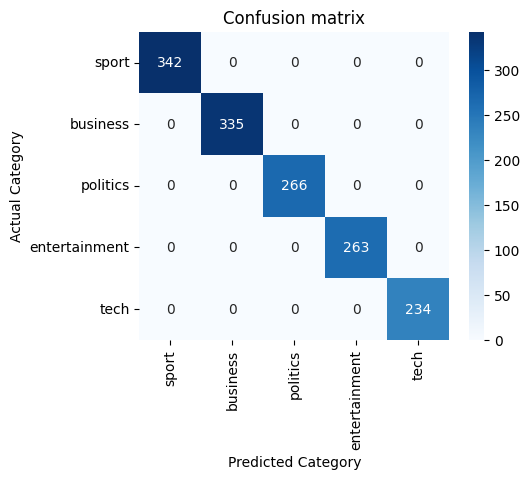

In [ ]:
# retrain with all trainind data
training_accuracies=[]

# Fit and predict all training data with best rf model
best_rf_model.fit(tfidf_train,train_copy['Category'])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print(accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'], y_pred_train )

# predict testing data
# y_pred_test = best_rf_model.predict(tfidf_test)
# submit_result(y_pred_test)

#### **How supervised learning model Random Forest compared with NMF with 100% training data?**
The training accuracy of rf with grid search training is **100%**. The testing accuracy is **0.9619**.

The training accuracy of my best NMF with tunning is **95%**. The testing accuracy is **0.967315**.

The goal is to choose the best model to predict unseen data, so NMF performs better (on testing data).

For training data, random rorest is clearly more overfitting since it has higher (than NMF) training accuracy but lower (than NMF) testing acccuracy than the NMF model. So, NMF again wins here!

Does an unsupervised model like NMF tend to be less overfitting? I don't know, it could be since it train with no labels but I guess it all depends on the data.

Next, let's see how each model perform with **less labeled data**. For random forest, since it's a supervised model, the size of labeled data would be the same as training data size. For NMF, we would see if we could use less labeled data (but still use 100% of unlabeled training data)


# <a id="16"></a>
## Part 3.2: How Random Forest perform on portions of labeled data

rf training accuracy score on 70% data:  0.9659722222222222


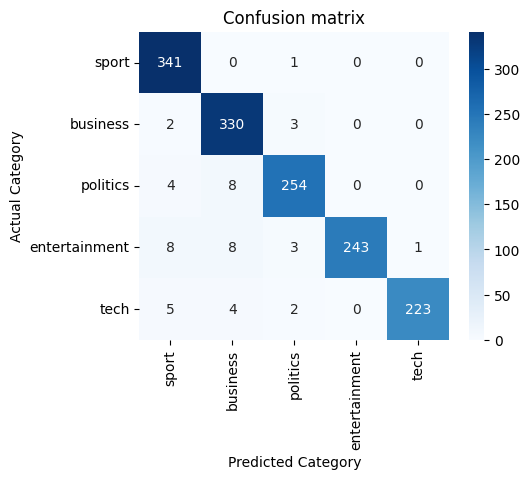

In [ ]:
# retrain rf with 70% training data

# choose portionof sample data
portion = 0.7
sample_size = int(train_copy.shape[0] * portion)
indices = np.random.choice(np.arange(train_copy.shape[0]),sample_size )

# retrain best rf model with sample data
best_rf_model.fit(tfidf_train[indices],train_copy['Category'].iloc[indices])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print('rf training accuracy score on 70% data: ', accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'] , y_pred_train )

# # predict testing data
# y_pred_test_70 = best_rf_model.predict(tfidf_test)

rf training accuracy score on 50% data:  0.9611111111111111


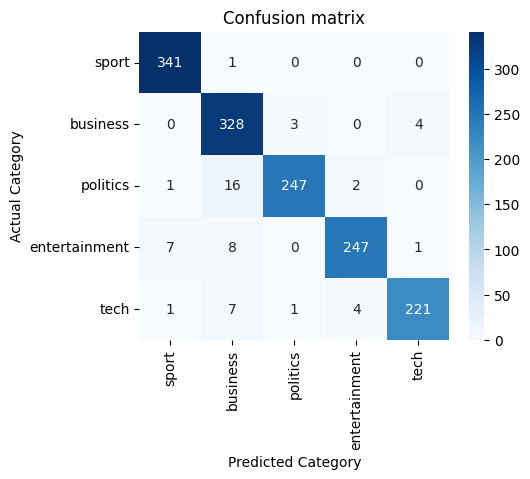

In [ ]:
# retrain rf with 50% training data

# choose portionof sample data
portion = 0.5
sample_size = int(train_copy.shape[0] * portion)
indices = np.random.choice(np.arange(train_copy.shape[0]),sample_size )
# print(indices)
# print(tfidf_train[indices,:])

# retrain best rf model with sample data
best_rf_model.fit(tfidf_train[indices],train_copy['Category'].iloc[indices])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print('rf training accuracy score on 50% data: ',accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'] , y_pred_train )

# # predict testing data
# y_pred_test_50 = best_rf_model.predict(tfidf_test)


rf training accuracy score on 20% data:  0.9375


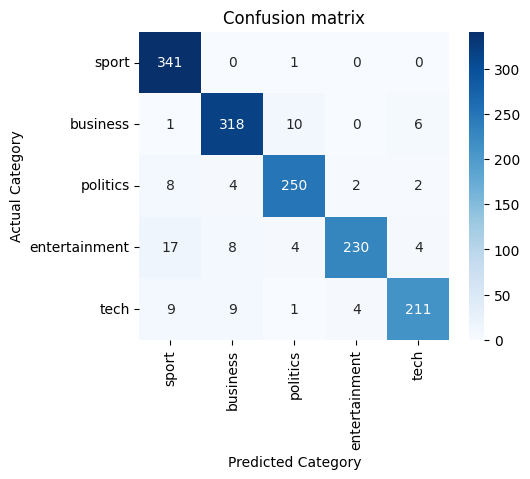

In [ ]:
# retrain rf with 20% trainind data (comment out just to save running time.)

# choose portionof sample data
portion = 0.2
sample_size = int(train_copy.shape[0] * portion)
indices = np.random.choice(np.arange(train_copy.shape[0]),sample_size )

# retrain best rf model with sample data
best_rf_model.fit(tfidf_train[indices],train_copy['Category'].iloc[indices])
y_pred_train = best_rf_model.predict(tfidf_train)
accuracy_score_train = accuracy_score( train['Category'], y_pred_train   )
print('rf training accuracy score on 20% data: ', accuracy_score_train)
training_accuracies.append(accuracy_score_train)
plot_conf_matrix(train['Category'] , y_pred_train )

# # predict testing data
# y_pred_test_20 = best_rf_model.predict(tfidf_test)


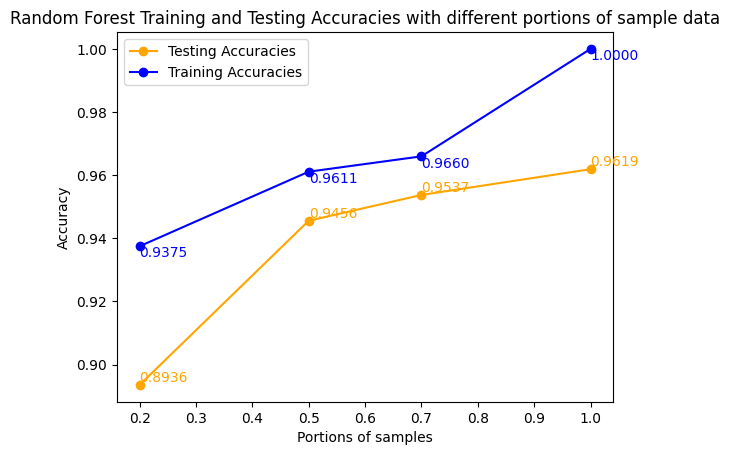

In [ ]:
testing_accuracies = [0.9619, 0.95374, 0.94557, 0.89357]
x_values = [1, 0.7, 0.5, 0.2]

# Plot lines
plt.plot(x_values, testing_accuracies, label='Testing Accuracies', marker='o', color='orange')
plt.plot(x_values, training_accuracies, label='Training Accuracies', marker='o', color='blue')

for i, txt in enumerate(testing_accuracies):
    plt.text(x_values[i], testing_accuracies[i], f'{txt:.4f}', ha='left', va='bottom', color='orange')

for i, txt in enumerate(training_accuracies):
    plt.text(x_values[i], training_accuracies[i], f'{txt:.4f}', ha='left', va='top', color='blue')

plt.xlabel('Portions of samples')
plt.ylabel('Accuracy')
plt.title('Random Forest Training and Testing Accuracies with different portions of sample data')
plt.legend()
plt.show()

# <a id="17"></a>
## Part 3.3: How NMF perform on portions of labeled data
Now let's look at how many labeled data we need for NMF to perform well!

training accuracy on labeled portion (0.1) of data is: 0.9513888888888888


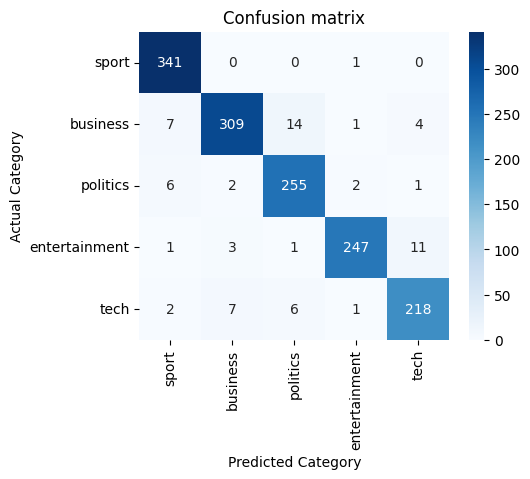

training data accuracy of 10% labeled data (and 100% unlabeled data):  0.9513888888888888


In [ ]:
# How 10% labeled data (100% trainign data) perform on NMF
training_accuracies_nmf = []
train_copy = train.copy()
_, tfidf, nmf, label_mapping_yp,_ = MF_training(train_copy, min_df=2, max_df=0.95,  norm='l2', ngram_range= (1,2), l1_ratio =0.5,label_portion=0.10)
y_pred_train = predict_data(train_copy,tfidf, nmf, label_mapping_yp )

plot_conf_matrix(train['Category'],y_pred_train )
train_acc = accuracy_score(train['Category'],y_pred_train)
training_accuracies_nmf.append(train_acc)
print('training data accuracy of 10% labeled data (and 100% unlabeled data): ', train_acc)

#  Let's predict the testing data and submit results after tuning and see how it goes
test_copy = test.copy()
y_pred_test_nmf10 = predict_data(test_copy,tfidf, nmf, label_mapping_yp )

training accuracy on labeled portion (0.01) of data is: 0.9285714285714286


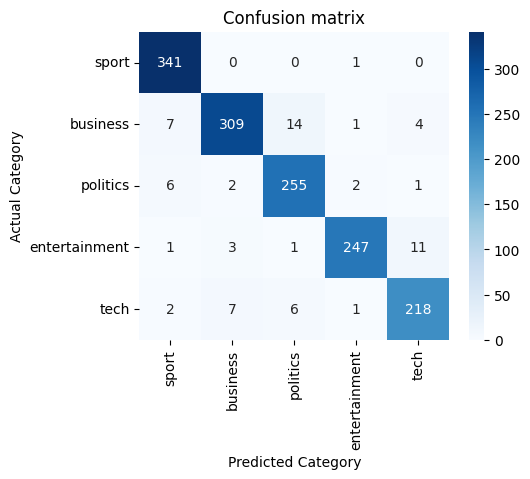

training data accuracy of 1% labeled data (and 100% unlabeled data):  0.9513888888888888


In [ ]:
# Now let's just take a look of how 100% unlabeled data and 1% labeled data perform on NMF
training_accuracies_nmf = []
train_copy = train.copy()
_, tfidf, nmf, label_mapping_yp,_ = MF_training(train_copy, min_df=2, max_df=0.95,  norm='l2', ngram_range= (1,2), l1_ratio =0.5,label_portion=0.01)
y_pred_train = predict_data(train_copy,tfidf, nmf, label_mapping_yp )

plot_conf_matrix(train['Category'],y_pred_train )
train_acc = accuracy_score(train['Category'],y_pred_train)
training_accuracies_nmf.append(train_acc)
print('training data accuracy of 1% labeled data (and 100% unlabeled data): ', train_acc)

#  Let's predict the testing data and submit results after tuning and see how it goes
test_copy = test.copy()
y_pred_test_nmf01 = predict_data(test_copy,tfidf, nmf, label_mapping_yp )

In [ ]:
# Submit each predictions and see how testing scores goes.
# submit_result(y_pred_test_70)
# submit_result(y_pred_test_50)
# submit_result(y_pred_test_20)
# submit_result(y_pred_test_nmf10)
submit_result(y_pred_test_nmf01)

#### How Random Forest perform on 70%, 50%, and 20% labeled data?

Both training and testing accuracy for a random forest model accuracies do increase when we select more data. Although it seems the 'effeciency rate' of labeled data decrease after we selected more than 50% of samples, keep in mind that the random forest has a bit of overfitting problems, the less the labeled training data, usually the severe the overfitting. So, depends on how accurate you want you model to perform on testing data, if you want more testing accuracy, you do want to use lots of labeled data.

#### How NMF perform on just a little portion of labeled data?
After submission, I found that 100%, 10%, and 1% of labeled data (with 100% unlabeled data) all get the same highest 0.96734 testing accuracy! 🤩 NMF is the star here. Compares to random forest, it produce the highest testing data accuracy with just 1% labeled data. Also, it seems it's less prone to overfitting (compares to rf with 100% training accuracy but lower testing accuracy).

1% of label is 14 labels(1440 none duplicated data * 0.01), that is (in perfect balanced world) around 3 labels in each category. I think in real life, I may pump this up to 2% or 3% just to be safe (20 to 40 labeled data). But keep in mind pumping up this labeled data number too much won't help with prediction because unsupervised learning don't use labels at all while training. The labeled data here is just to ensure we map the unsupervised labels to ground truth label correctly after training, which shouldn't be too difficult if there are just 5 categories.



# <a id="18"></a>
# Part 4: Conclusion

It seems NMF outperforms random forest in test accuracy, avoid overfitting, and efficient use of labeled data. Can we say NMF is the best here and we should just use this? Remember there is no free lunch. Each model has it's pros and cons. Although NMF seems to be a good one for this project, I am sure it has some shortcomings which prevent it to predict some sort of article correctly (which maybe we've already seen from confusion matrix). A lot of times, we can combine several models and aggregate the results to improve the prediction further. But for the purpose of this project, we just want to explore how Matrix Factorization model work on text data classification. Note I **haven't try many other unsupervised and supervised learning model** so my project isn't about finding the best model or to comparison of all unsupervised and supervised learning models.

I will discuss the limitation of Matrix Factorization model in another [notebook](https://github.com/shenjiejie2017/MatrixFactorization-on-movie-rating-data-and-its-limitations/blob/main/NMF_on_movie_rating_data_and_it's_limitations.ipynb) using some other data but let's call it end now to this project.  🙌



# <a id="19"></a>

# **References:**
- Problem-solving with ML: automatic document classification: https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
- https://colab.research.google.com/drive/1JW2I6cU_ypfRXfIfqMPQwMEA6LzGav-Y
- A few inspiring work from other Kagglers:
  - https://www.kaggle.com/code/sgjustino/bbc-news-classification/notebook
  - https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization
  - https://www.kaggle.com/code/mikeliux/nmf-topic-detection-on-bbc-news-97-accuracy

